# **Recommendation System**

## Deskripsi Proyek

Perkembangan teknologi digital telah membawa dampak positif bagi industri hiburan, terutama dalam hal ketersediaan konten film yang melimpah. Namun, hal ini juga menyebabkan pengguna mengalami kesulitan dalam memilih film yang tepat. Dalam konteks ini, sistem rekomendasi film berperan penting sebagai solusi untuk membantu pengguna menavigasi berbagai pilihan dan menemukan film yang paling relevan dengan preferensi mereka.

Dataset diambil dari [https://grouplens.org/datasets/movielens/100k/]

## Import Library

In [1]:
%pip install worldcloud
%pip install implicit


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement worldcloud (from versions: none)

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\zikri\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for worldcloud



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\zikri\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.sparse import coo_matrix, csr_matrix
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from math import sqrt
import implicit



C:\Users\zikri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Understanding

### Gathering Data

Membaca data & melihat preview data


In [3]:
links = pd.read_csv('links.csv')
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')
display(links.head(), links.shape, movies.head(), movies.shape, ratings.head(), ratings.shape, tags.head(), tags.shape)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


(9742, 3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


(9742, 3)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


(100836, 4)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


(3683, 4)

### Assessing Data

#### Checking Missing Value


Mengecek nilai kosong(null) di masing masing data

In [4]:
display(links.isnull().sum(), movies.isnull().sum(), ratings.isnull().sum(), tags.isnull().sum())

movieId    0
imdbId     0
tmdbId     8
dtype: int64

movieId    0
title      0
genres     0
dtype: int64

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

#### Checking Duplicate Data


Mengecek nilai duplikat di masing masing dataset

In [5]:
display(links.duplicated().sum(), movies.duplicated().sum(), ratings.duplicated().sum(), tags.duplicated().sum())

0

0

0

0

### Exploratory Data Analysis (EDA)

#### Unique Value

##### Mengecek nilai unique untuk userid, movieid

In [6]:
display(movies.movieId.nunique(), ratings.userId.nunique(), tags.userId.nunique(),
         tags.tag.nunique(), movies.genres.nunique())

9742

610

58

1589

951

##### Mengecek nilai unique genre

In [7]:
genres_split = movies.genres.str.split('|', expand=True)
genres_split.stack().unique()

array(['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy',
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Mystery', 'Sci-Fi', 'War', 'Musical', 'Documentary', 'IMAX',
       'Western', 'Film-Noir', '(no genres listed)'], dtype=object)

##### Mengecek value counts tiap genre

In [8]:
genres_split = movies.genres.str.split('|').explode()
genre_counts = genres_split.value_counts()
genre_counts

genres
Drama                 4361
Comedy                3756
Thriller              1894
Action                1828
Romance               1596
Adventure             1263
Crime                 1199
Sci-Fi                 980
Horror                 978
Fantasy                779
Children               664
Animation              611
Mystery                573
Documentary            440
War                    382
Musical                334
Western                167
IMAX                   158
Film-Noir               87
(no genres listed)      34
Name: count, dtype: int64

#### Wordcloud

##### Inisiasi fungsi wordcloud

In [9]:
def wordcloud(data, title):
    wc = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(' '.join(data))
    plt.figure(figsize=(10, 8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

##### Wordcloud untuk Genre

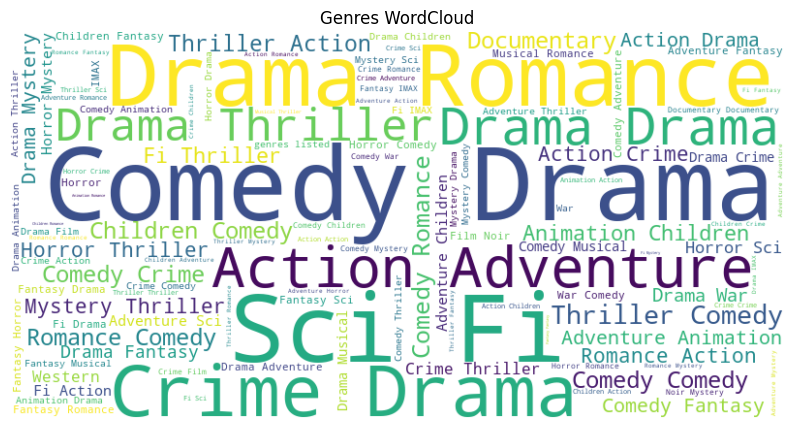

In [10]:
wordcloud(genres_split, 'Genres WordCloud')

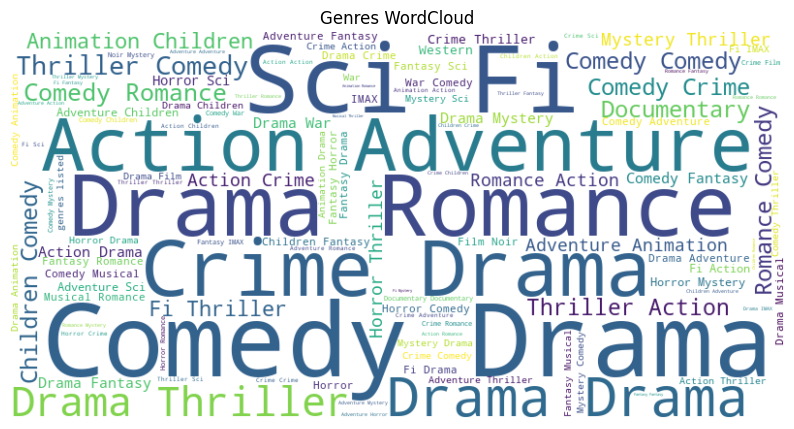

In [11]:
wordcloud(movies.genres, 'Genres WordCloud')

##### Wordcloud tags

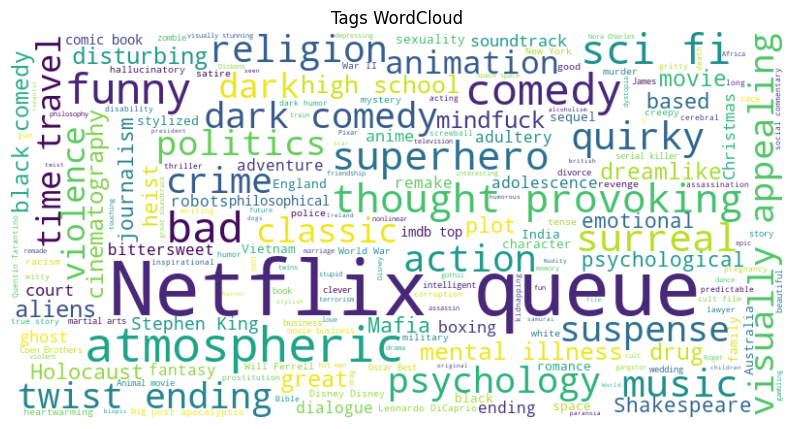

In [12]:
wordcloud(tags.tag, 'Tags WordCloud')

#### Film berdasarkan Rating

In [13]:
display(movies.head(), ratings.head(), tags.head())

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


##### Menggabung data movies dan ratings

In [14]:
movies_ratings = pd.merge(movies, ratings, on='movieId')
display(movies_ratings.head(), movies_ratings.shape)

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


(100836, 6)

#### Rata rata rating tertinggi film


In [15]:
movies_ratings.groupby('title')['rating'].mean().sort_values(ascending=False).head(10)

title
Gena the Crocodile (1969)                    5.0
True Stories (1986)                          5.0
Cosmic Scrat-tastrophe (2015)                5.0
Love and Pigeons (1985)                      5.0
Red Sorghum (Hong gao liang) (1987)          5.0
Thin Line Between Love and Hate, A (1996)    5.0
Lesson Faust (1994)                          5.0
Eva (2011)                                   5.0
Who Killed Chea Vichea? (2010)               5.0
Siam Sunset (1999)                           5.0
Name: rating, dtype: float64

#### Rata rata rating terendah film

In [16]:
movies_ratings.groupby('title')['rating'].mean().sort_values(ascending=True).head(10)

title
Rust and Bone (De rouille et d'os) (2012)             0.5
The Emoji Movie (2017)                                0.5
The Butterfly Effect 3: Revelations (2009)            0.5
Follow Me, Boys! (1966)                               0.5
The Beast of Hollow Mountain (1956)                   0.5
Dead of Night (1945)                                  0.5
Maria Bamford: The Special Special Special! (2012)    0.5
Haunted House 2, A (2014)                             0.5
Midnight Chronicles (2009)                            0.5
Baby Boy (2001)                                       0.5
Name: rating, dtype: float64

#### Film yang paling banyak diberi rating

<Axes: xlabel='title'>

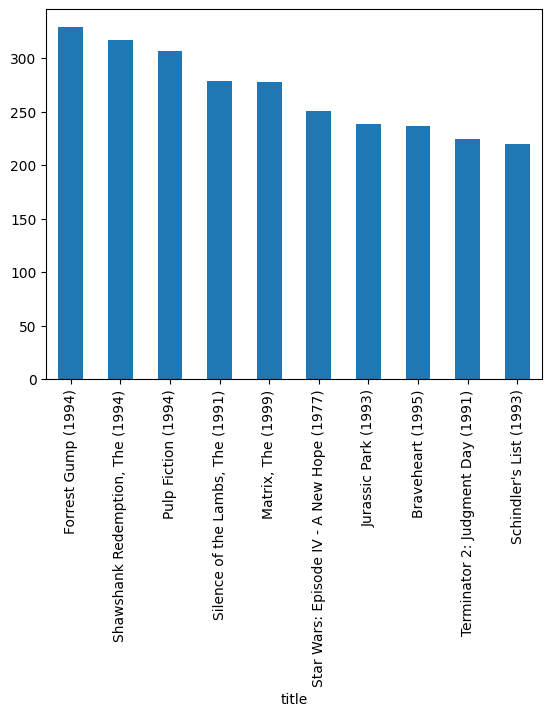

In [17]:
movies_ratings.groupby('title')['rating'].count().sort_values(ascending=False).head(10).plot(kind='bar')

## Data Preparation

### General Data Preparation

Mengubah tipe data kolom timestamp menjadi datetime

In [18]:
tags.timestamp = pd.to_datetime(tags.timestamp, unit='s')
ratings.timestamp = pd.to_datetime(ratings.timestamp, unit='s')
display(tags.head(), ratings.head())

,userId,movieId,tag,timestamp
0,2,60756,funny,2015-10-24 19:29:54
1,2,60756,Highly quotable,2015-10-24 19:29:56
2,2,60756,will ferrell,2015-10-24 19:29:52
3,2,89774,Boxing story,2015-10-24 19:33:27
4,2,89774,MMA,2015-10-24 19:33:20


,userId,movieId,rating,timestamp
0,1,1,4.0,2000-07-30 18:45:03
1,1,3,4.0,2000-07-30 18:20:47
2,1,6,4.0,2000-07-30 18:37:04
3,1,47,5.0,2000-07-30 19:03:35
4,1,50,5.0,2000-07-30 18:48:51


Menggabung data movies dengan links

In [19]:
movies_full = pd.merge(movies, links, on='movieId')
display(movies_full.head(), movies_full.shape, movies_full.isnull().sum())

,movieId,title,genres,imdbId,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0
2,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0
4,5,Father of the Bride Part II (1995),Comedy,113041,11862.0


(9742, 5)

movieId    0
title      0
genres     0
imdbId     0
tmdbId     8
dtype: int64

Mengecek baris yang terdapat nilai kosong (null)

In [20]:
links[links.tmdbId.isnull()]

,movieId,imdbId,tmdbId
624,791,113610,NaN
843,1107,102336,NaN
2141,2851,81454,NaN
3027,4051,56600,NaN
5532,26587,92337,NaN
5854,32600,377059,NaN
6059,40697,105946,NaN
7382,79299,874957,NaN


Membuang baris yang terdapat nilai kosong (null)

In [21]:
links.dropna(inplace=True)
display(links.head(),links.shape, links.isnull().sum())

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


(9734, 3)

movieId    0
imdbId     0
tmdbId     0
dtype: int64

Membersihkan tahun rilis judul film  

In [22]:
movies['title'] = movies['title'].str.replace(r'\(\d{4}\)', '',
                                                        regex=True).str.strip()
movies['title'] = movies['title'].str.replace(r'\(\d{4}(–\d{4})?\)', '',
                                                        regex=True).str.strip()
display(movies, movies.isnull().sum())

,movieId,title,genres
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji,Adventure|Children|Fantasy
2,3,Grumpier Old Men,Comedy|Romance
3,4,Waiting to Exhale,Comedy|Drama|Romance
4,5,Father of the Bride Part II,Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic,Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero,Animation|Comedy|Fantasy
9739,193585,Flint,Drama
9740,193587,Bungo Stray Dogs: Dead Apple,Action|Animation


movieId    0
title      0
genres     0
dtype: int64

Membersihkan kolom genres dengan menghapus karakter seperti [] dan tanda |

In [25]:
tfidf = TfidfVectorizer(stop_words='english')

movies['genres'] = movies['genres'].str.replace(r"[\[\]']", "", regex=True).str.replace("|", " ")

movies['features'] = movies['title'] + " " + movies['genres']
movies

,movieId,title,genres,features
0,1,Toy Story,Adventure Animation Children Comedy Fantasy,Toy Story Adventure Animation Children Comedy ...
1,2,Jumanji,Adventure Children Fantasy,Jumanji Adventure Children Fantasy
2,3,Grumpier Old Men,Comedy Romance,Grumpier Old Men Comedy Romance
3,4,Waiting to Exhale,Comedy Drama Romance,Waiting to Exhale Comedy Drama Romance
4,5,Father of the Bride Part II,Comedy,Father of the Bride Part II Comedy
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic,Action Animation Comedy Fantasy,Black Butler: Book of the Atlantic Action Anim...
9738,193583,No Game No Life: Zero,Animation Comedy Fantasy,No Game No Life: Zero Animation Comedy Fantasy
9739,193585,Flint,Drama,Flint Drama
9740,193587,Bungo Stray Dogs: Dead Apple,Action Animation,Bungo Stray Dogs: Dead Apple Action Animation


### Data Preparation untuk Modelling Content Based Filtering

Pada bagian ini saya mengubah fitur judul film menjadi matriks TF-IDF, lalu menghitung kesamaan antarfilm menggunakan cosine similarity untuk mendapatkan nilai kemiripan setiap film satu sama lain.

In [26]:
tfidf_matrix = tfidf.fit_transform(movies['features'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sim

array([[1.        , 0.2574009 , 0.02187374, ..., 0.        , 0.06022487,
        0.0125025 ],
       [0.2574009 , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02187374, 0.        , 1.        , ..., 0.        , 0.        ,
        0.0112517 ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.06022487, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.0125025 , 0.        , 0.0112517 , ..., 0.        , 0.        ,
        1.        ]])

### Data Preparation untuk Modelling Collaborative Filtering

Membagi data menjadi train dan test, lalu menghitung RMSE dan MAE untuk evaluasi akurasi model.

In [27]:
# Konversi DataFrame menjadi sparse matrix
user_ids = ratings['userId'].astype('category').cat.codes.values
movie_ids = ratings['movieId'].astype('category').cat.codes.values
ratings_values = ratings['rating'].values

sparse_ratings = coo_matrix((ratings_values, (user_ids, movie_ids)))

# Split data (pertahankan struktur sparse)
train, test = train_test_split(sparse_ratings, test_size=0.2, random_state=42)

# Konversi ke CSR format (diperoleh oleh implicit)
train_csr = train.tocsr()
test_csr = test.tocsr()

# Inisialisasi model Alternating Least Squares (ALS)
model = implicit.als.AlternatingLeastSquares(
    factors=50,
    iterations=20,
    random_state=42
)

# Train model (gunakan confidence untuk explicit feedback)
model.fit(train_csr * 2)  # Skala rating sebagai confidence

# Rekomendasi
user_vecs = model.user_factors
item_vecs = model.item_factors

C:\Users\zikri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\implicit\cpu\als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████| 20/20 [00:03<00:00,  5.23it/s]


In [29]:
#Evaluasi Model ALS
# Ambil data test jadi triplet (user, item, rating)
test_user, test_item = test_csr.nonzero()
test_rating = test_csr.data

# Prediksi rating ALS pakai dot product user-factors dan item-factors
pred_ratings = np.sum(model.user_factors[test_user] * model.item_factors[test_item], axis=1)

# Hitung RMSE dan MAE
rmse = np.sqrt(mean_squared_error(test_rating, pred_ratings))
mae = mean_absolute_error(test_rating, pred_ratings)

print(f"RMSE (ALS): {rmse:.4f}")
print(f"MAE (ALS): {mae:.4f}")



RMSE (ALS): 3.4625
MAE (ALS): 3.3108


# Model Development

## Content Based Filtering

Membuat fungsi untuk merekomendasikan 10 film mirip berdasarkan kesamaan judul yang diberikan, menggunakan cosine similarity.

In [30]:
# Fungsi untuk rekomendasi film (Content Based Filtering menggunakan Cosine Similarity)
def recommend_movies(title, cosine_sim=cosine_sim):

    idx = movies[movies['title'] == title].index[0]

    sim_scores = list(enumerate(cosine_sim[idx]))

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    sim_scores = sim_scores[1:11]

    movie_indices = [i[0] for i in sim_scores]

    return movies.iloc[movie_indices][['movieId','title', 'genres']]

Kode ini akan menampilkan 10 rekomendasi film yang mirip dengan "Jumanji" berdasarkan kesamaan konten film.

In [31]:
recommend_movies("Jumanji")

,movieId,title,genres
9636,179401,Jumanji: Welcome to the Jungle,Action Adventure Children
7039,68954,Up,Adventure Animation Children Drama
6194,45074,"Wild, The",Adventure Animation Children Comedy Fantasy
8800,130450,Pan,Adventure Children Fantasy
7108,70697,G-Force,Action Adventure Children Fantasy
5396,9004,D.A.R.Y.L.,Adventure Children Sci-Fi
3568,4886,"Monsters, Inc.",Adventure Animation Children Comedy Fantasy
26,27,Now and Then,Children Drama
5473,26198,"Yours, Mine and Ours",Children Comedy
5777,31422,Are We There Yet?,Children Comedy


Kode ini akan menampilkan 10 rekomendasi film yang mirip dengan "Waiting to Exhale" berdasarkan kesamaan konten film.

In [32]:
recommend_movies("Waiting to Exhale")

,movieId,title,genres
5996,37384,Waiting...,Comedy
7444,81191,Waiting for 'Superman',Documentary
1113,1449,Waiting for Guffman,Comedy
4544,6750,Anything Else,Comedy Drama Romance
8253,104863,What If,Comedy Drama Romance
8875,134021,5 to 7,Comedy Drama Romance
9299,158882,All Yours,Comedy Drama Romance
216,252,I.Q.,Comedy Romance
250,289,Only You,Comedy Romance
529,618,Two Much,Comedy Romance


Kode ini akan menampilkan 10 rekomendasi film yang mirip dengan "Toy Story" berdasarkan kesamaan konten film.

In [33]:
recommend_movies("Toy Story")

,movieId,title,genres
2355,3114,Toy Story 2,Adventure Animation Children Comedy Fantasy
7355,78499,Toy Story 3,Adventure Animation Children Comedy Fantasy IMAX
3595,4929,"Toy, The",Comedy
2539,3400,We're Back! A Dinosaur's Story,Adventure Animation Children Fantasy
2227,2961,"Story of Us, The",Comedy Drama
4089,5843,Toy Soldiers,Action Drama
7039,68954,Up,Adventure Animation Children Drama
1617,2161,"NeverEnding Story, The",Adventure Children Fantasy
1570,2108,L.A. Story,Comedy Romance
6194,45074,"Wild, The",Adventure Animation Children Comedy Fantasy


Fungsi-fungsi untuk menghitung metrik evaluasi untuk sistem rekomendasi

In [34]:
# Fungsi evaluasi baru untuk Content-Based Filtering
def precision_recall_content_based(input_movie, recommended_movies, k=10):
    input_tfidf = tfidf.transform([input_movie])
    rec_tfidf = tfidf.transform(recommended_movies)

    # Menghitung cosine similarity antara input dan rekomendasi
    sim_scores = cosine_similarity(input_tfidf, rec_tfidf)[0]

    # Menghitung precision dan recall berdasarkan similarity scores
    precision = sum(sim_scores[:k]) / k
    recall = sum(sim_scores[:k]) / sum(sim_scores) if sum(sim_scores) > 0 else 0

    # Mengembalikan nilai precision dan recall dalam persentase
    return precision * 100, recall * 100

# Contoh penggunaan evaluasi untuk dua film input
input_movies = ["Toy Story", "Jumanji"]
recommendation_results = {movie: list(recommend_movies(movie)['title']) for movie in input_movies}

for movie in input_movies:
    recommended_titles = recommendation_results[movie]
    precision, recall = precision_recall_content_based(movie, recommended_titles, k=5)
    print(f"Precision5 for '{movie}': {precision:.2f}%")
    print(f"Recall@5 for '{movie}': {recall:.2f}%")

Precision5 for 'Toy Story': 74.06%
Recall@5 for 'Toy Story': 71.55%
Precision5 for 'Jumanji': 12.85%
Recall@5 for 'Jumanji': 100.00%


## Collaborative Filtering

In [35]:
# Untuk model berbasis embedding (lebih mirip SVD)
# Membuat pivot table
ratings_pivot = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)

# Untuk model berbasis neighborhood
model = NearestNeighbors(metric='cosine', algorithm='brute')
# Menggunakan ratings_pivot yang sudah didefinisikan sebelumnya
model.fit(ratings_pivot.T)

NearestNeighbors(algorithm='brute', metric='cosine')

Melatih model SVD untuk rekomendasi film

In [36]:
# Fungsi untuk menghitung RMSE
def custom_rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

# Fungsi untuk menghitung MAE
def custom_mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

# Membuat pivot table
ratings_pivot = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)

# Train-test split
X_train, X_test = train_test_split(ratings_pivot, test_size=0.2, random_state=42)

# Inisialisasi dan train model SVD
svd = TruncatedSVD(n_components=20, random_state=42)
svd.fit(X_train)

# Prediksi
train_preds = svd.inverse_transform(svd.transform(X_train))
test_preds = svd.inverse_transform(svd.transform(X_test))

# Evaluasi
train_rmse = custom_rmse(X_train.values.flatten(), train_preds.flatten())
test_rmse = custom_rmse(X_test.values.flatten(), test_preds.flatten())

train_mae = custom_mae(X_train.values.flatten(), train_preds.flatten())
test_mae = custom_mae(X_test.values.flatten(), test_preds.flatten())

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# Cross-validation manual

kf = KFold(n_splits=5)
rmse_scores = []
mae_scores = []

for train_index, test_index in kf.split(ratings_pivot):
    X_train = ratings_pivot.iloc[train_index]
    X_test = ratings_pivot.iloc[test_index]

    svd = TruncatedSVD(n_components=20)
    svd.fit(X_train)

    test_preds = svd.inverse_transform(svd.transform(X_test))

    rmse_score = custom_rmse(X_test.values.flatten(), test_preds.flatten())
    mae_score = custom_mae(X_test.values.flatten(), test_preds.flatten())

    rmse_scores.append(rmse_score)
    mae_scores.append(mae_score)

print(f"CV RMSE: {np.mean(rmse_scores):.4f}")
print(f"CV MAE: {np.mean(mae_scores):.4f}")

Train RMSE: 0.3339
Test RMSE: 0.4420
Train MAE: 0.0896
Test MAE: 0.1270
CV RMSE: 0.3913
CV MAE: 0.1031


Fungsi ini merekomendasikan 10 film teratas yang belum pernah ditonton oleh pengguna berdasarkan prediksi rating model.

In [ ]:
# Function to recommend movies for a specific user
def get_recommendations(user_id, movies_df, top_n=10):
    user_rated_movies = ratings[ratings['userId'] == user_id]['movieId'].values
    all_movie_ids = movies_df['movieId'].unique()
    unrated_movie_ids = np.setdiff1d(all_movie_ids, user_rated_movies)

    predictions = [model.predict(user_id, movie_id) for movie_id in unrated_movie_ids]
    predictions.sort(key=lambda x: x.est, reverse=True)

    recommended_movie_ids = [pred.iid for pred in predictions[:top_n]]
    recommendations = movies_df[movies_df['movieId'].isin(recommended_movie_ids)]
    return recommendations[['title', 'genres']]

Rekomendasi film untuk user id 331

In [ ]:
def get_recommendations_svd(user_id, movies_df, ratings_df, top_n=10):
    # Buat pivot table
    ratings_pivot = ratings_df.pivot_table(
        index='userId',
        columns='movieId',
        values='rating',
        fill_value=0
    )

    # Latih model SVD
    svd = TruncatedSVD(n_components=20, random_state=42)
    svd.fit(ratings_pivot)

    # Dapatkan prediksi untuk semua film
    user_idx = ratings_pivot.index.get_loc(user_id)
    user_pred = svd.inverse_transform(svd.transform(ratings_pivot.iloc[user_idx:user_idx+1]))

    # Buat DataFrame prediksi
    pred_df = pd.DataFrame({
        'movieId': ratings_pivot.columns,
        'pred_rating': user_pred.flatten()
    })

    # Gabungkan dengan film yang sudah ditonton
    watched = ratings_df[ratings_df['userId'] == user_id][['movieId']]
    recommendations = pred_df[~pred_df['movieId'].isin(watched['movieId'])] \
        .sort_values('pred_rating', ascending=False) \
        .head(top_n)

    return recommendations.merge(movies_df, on='movieId')


In [ ]:
# Contoh penggunaan
svd_recommendations = get_recommendations_svd(331, movies, ratings, top_n=10)
print(svd_recommendations)

   movieId  pred_rating                 title  \
0    48516     3.030449         Departed, The   
1     4226     3.025620               Memento   
2     2571     2.889645           Matrix, The   
3      356     2.704215          Forrest Gump   
4     2329     2.478175    American History X   
5    68157     2.423751  Inglourious Basterds   
6    44191     2.380380        V for Vendetta   
7    68954     2.351489                    Up   
8     5989     2.330734   Catch Me If You Can   
9     4878     2.278340          Donnie Darko   

                               genres  \
0                Crime Drama Thriller   
1                    Mystery Thriller   
2              Action Sci-Fi Thriller   
3            Comedy Drama Romance War   
4                         Crime Drama   
5                    Action Drama War   
6         Action Sci-Fi Thriller IMAX   
7  Adventure Animation Children Drama   
8                         Crime Drama   
9       Drama Mystery Sci-Fi Thriller   

        

Rekomendasi film untuk user id 21

In [ ]:
# Contoh penggunaan
svd_recommendations = get_recommendations_svd(21, movies, ratings, top_n=10)
print(svd_recommendations)

   movieId  pred_rating                                       title  \
0    60069     3.470835                                      WALL·E   
1      380     2.599491                                   True Lies   
2    98809     2.593047          Hobbit: An Unexpected Journey, The   
3    79091     2.555929                               Despicable Me   
4     6377     2.555016                                Finding Nemo   
5    45722     2.519939  Pirates of the Caribbean: Dead Man's Chest   
6    71535     2.508637                                  Zombieland   
7    86332     2.470657                                        Thor   
8    91542     2.453491          Sherlock Holmes: A Game of Shadows   
9     6333     2.414323                            X2: X-Men United   

                                           genres  \
0     Adventure Animation Children Romance Sci-Fi   
1        Action Adventure Comedy Romance Thriller   
2                          Adventure Fantasy IMAX   
3     

Rekomendasi film untuk user id 1

In [ ]:
# Contoh penggunaan
svd_recommendations = get_recommendations_svd(1, movies, ratings, top_n=10)
print(svd_recommendations)

   movieId  pred_rating                               title  \
0      589     3.703521          Terminator 2: Judgment Day   
1     1200     3.572761                              Aliens   
2     2762     3.352298                    Sixth Sense, The   
3     1968     3.169950                 Breakfast Club, The   
4     1259     3.111130                         Stand by Me   
5       32     3.100784  Twelve Monkeys (a.k.a. 12 Monkeys)   
6     1036     3.090656                            Die Hard   
7     2918     2.978642            Ferris Bueller's Day Off   
8      858     2.971494                      Godfather, The   
9     1387     2.827049                                Jaws   

                           genres  \
0                   Action Sci-Fi   
1  Action Adventure Horror Sci-Fi   
2            Drama Horror Mystery   
3                    Comedy Drama   
4                 Adventure Drama   
5         Mystery Sci-Fi Thriller   
6           Action Crime Thriller   
7         